# MV segmentation

In [14]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import utils as utils
from data_loader import *
from unet import *
from trainer import *
from transforms import *
import random

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# If using GPU (CUDA or MPS)
if torch.backends.mps.is_available():
    # Enable MPS deterministic behavior
    torch.mps.manual_seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading and preprocessing the data

In [2]:
# load data
train_data = utils.load_zipped_pickle("train.pkl")
test_data = utils.load_zipped_pickle("test.pkl")

In [3]:
names, images, masks = utils.preprocess_train_data(train_data)
test_names, test_videos = utils.preprocess_test_data(test_data)

100%|██████████| 20/20 [01:11<00:00,  3.55s/it]


Indices of samples shown:  [  4 151  90]


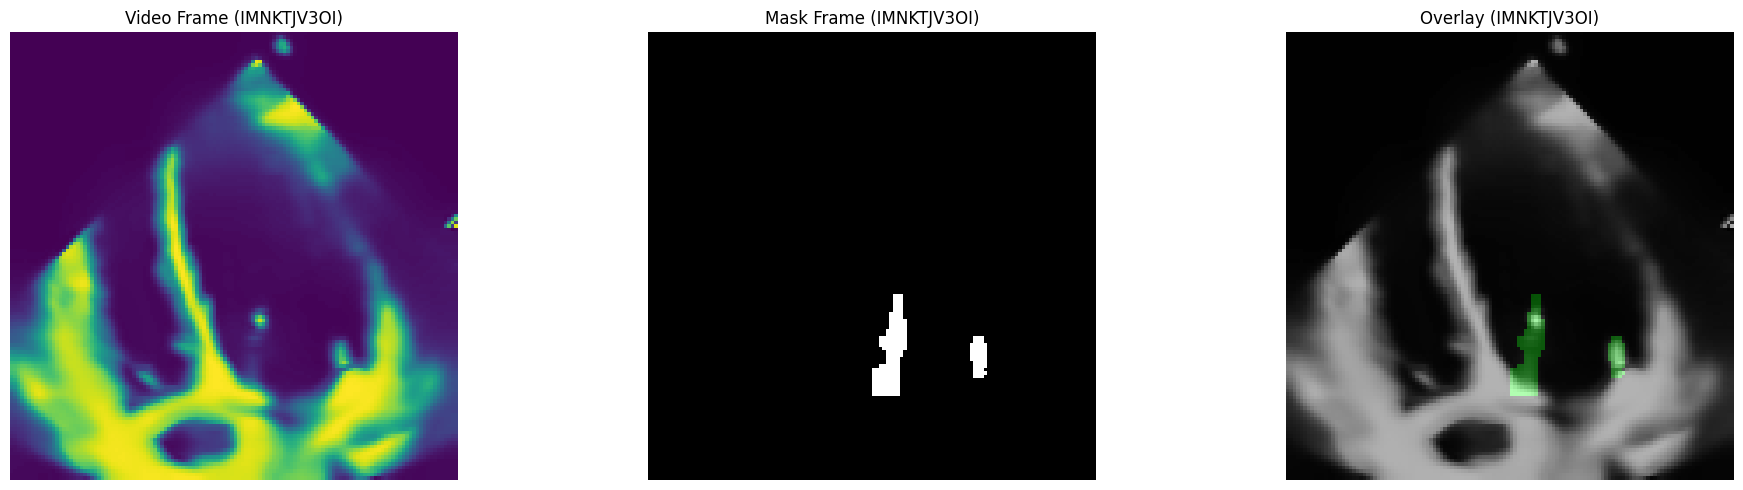

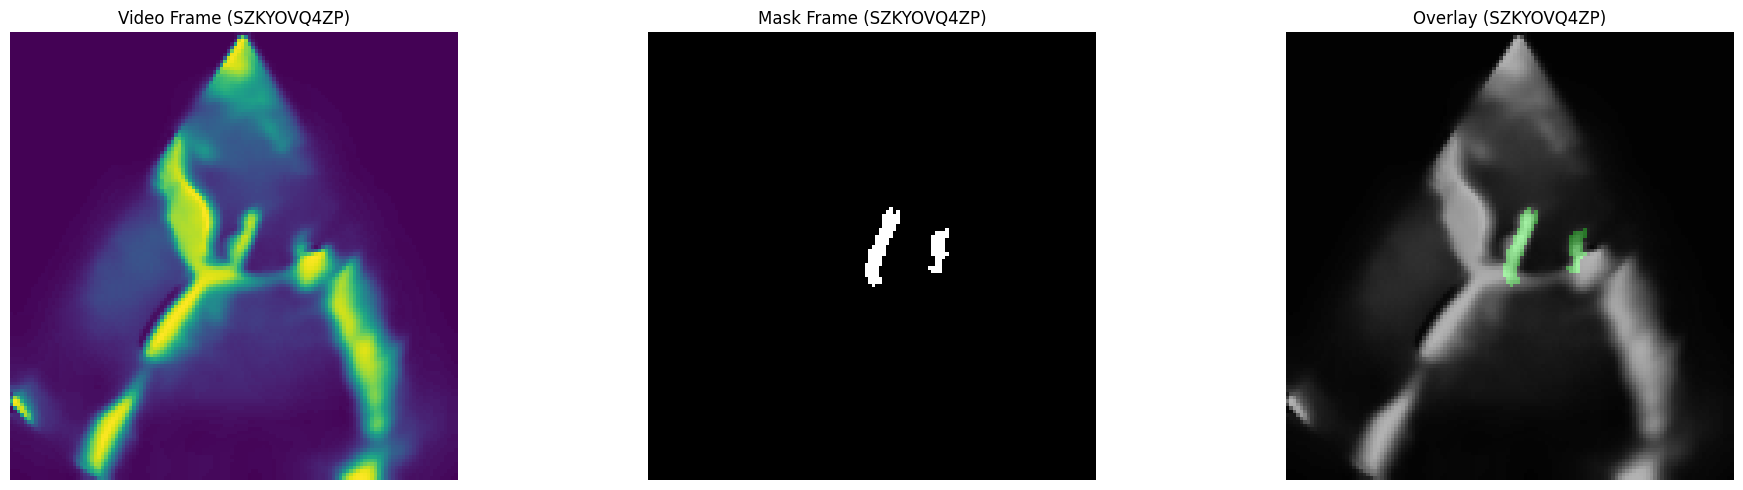

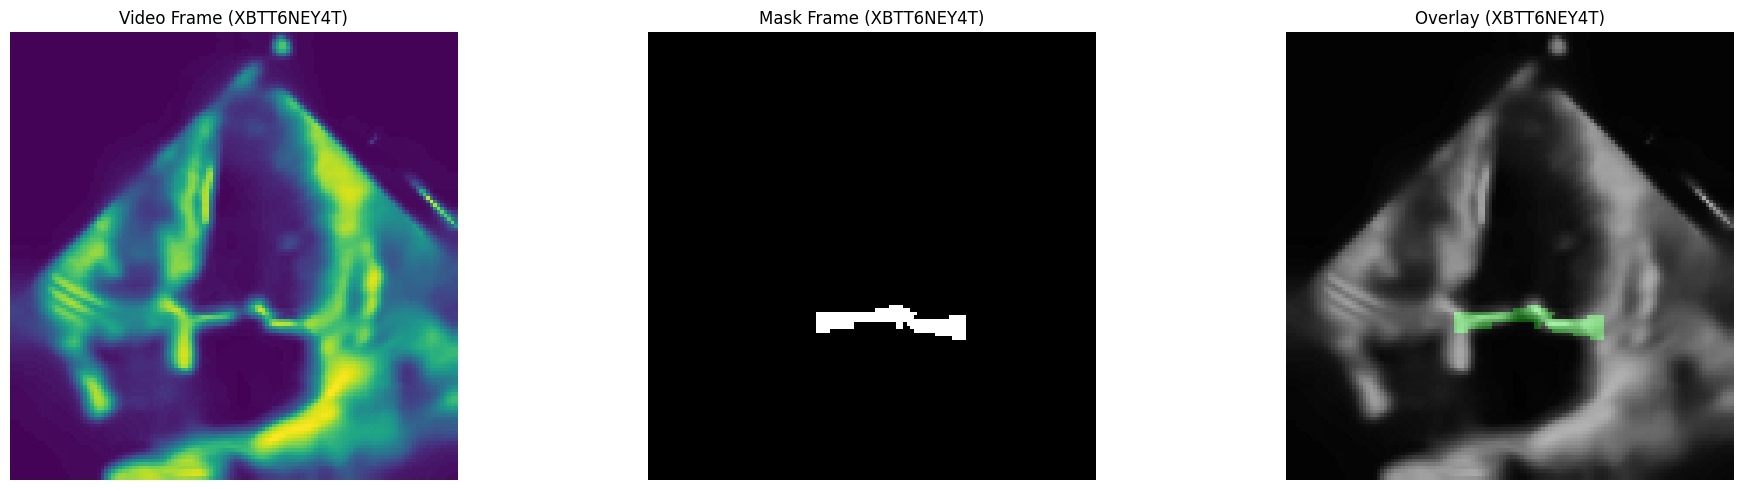

In [5]:
utils.visualize_data(images, masks, names, num_samples=3)

### Different channels after preprocessing

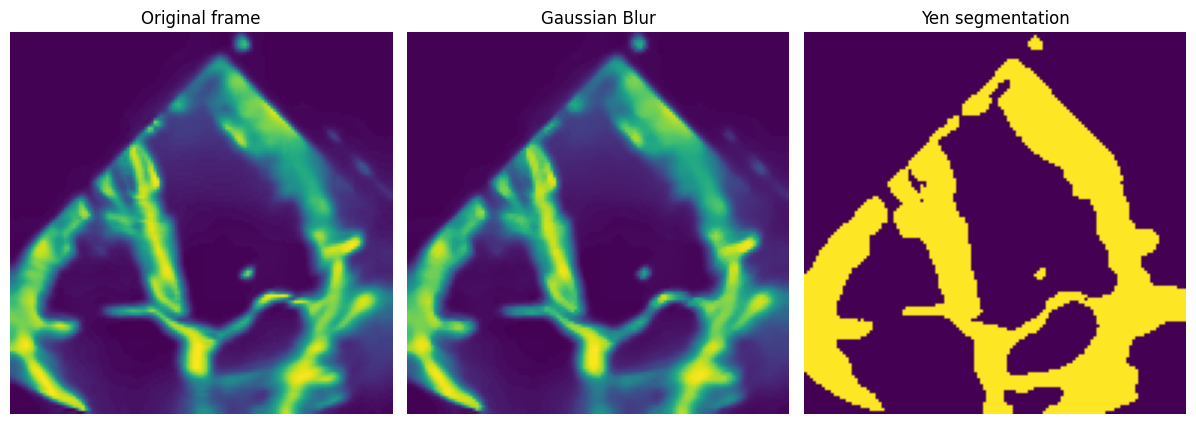

In [6]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.imshow(images[0][:, :, 0])
plt.title(f"Original frame")
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(images[0][:, :, 1])
plt.title(f"Gaussian Blur")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(images[0][:, :, 2])
plt.title(f"Yen segmentation")
plt.axis('off') 

plt.tight_layout()
plt.show()

# Training

The weights of the model were saved in a .pth file in the models directory to prevent having to train the model repeatedly.

In [7]:
BATCH_SIZE = 5

images_train, images_valid, masks_train, masks_valid = train_test_split(images, masks, test_size=0.2, random_state=seed_value, shuffle=True)

print("Before replication:", len(images_train), len(images_valid))

# replicate data points to perform data augmentation
images_train = images_train * 10
masks_train = masks_train * 10

print("After replication:", len(images_train), len(images_valid))

train_loader = get_loader(images_train, masks_train, BATCH_SIZE, mode="train")
valid_loader = get_loader(images_valid, masks_valid, BATCH_SIZE)

Before replication: 156 39
After replication: 1560 39


In [8]:
class Config:
    lr = 0.0001
    num_epochs = 30
    model_path = "models"

trainer = Trainer(Config, train_loader, valid_loader)

Using mps device


In [ ]:
models = {
    "U_Net": UNet(n_classes=1, n_channels=3, bilinear=False),
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    best_val_jaccard = trainer.train_and_evaluate(model, model_name)
    results[model_name] = {
        "Validation Median Jaccard": best_val_jaccard,
    }

print("Final Results:")
for model_name, scores in results.items():
    print(f"{model_name}: {scores}")

# Output visualization

In [ ]:
device = ("cuda"
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu"
         )
print(f"Using {device} device\n")

model = UNet(n_classes=1, n_channels=3, bilinear=False).to(device)

# Load the model weights
model.load_state_dict(torch.load('models/U_Net_best.pth', map_location=device))

### Train image visualization

In [10]:
model.eval()

with torch.no_grad():
    idx = 40

    input_tensor = torch.from_numpy(images[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
    output_mask = model(input_tensor.float())
    output_mask = torch.sigmoid(output_mask)

    binary_mask = (output_mask >= 0.8).float()

##### Original image and mask prediction

In [ ]:
utils.visualize_data([images[idx]], [binary_mask.squeeze(0).permute(1, 2, 0).to("cpu").detach().numpy()], [names[idx]], num_samples=1)

##### True mask

In [ ]:
plt.imshow(masks[idx])

### Test image visualization

In [ ]:
idx = 8

input_tensor = torch.from_numpy(test_videos[idx]).permute(2, 0, 1).unsqueeze(0).to(device)

output_mask = model(input_tensor.float())
output_mask = torch.sigmoid(output_mask)

binary_mask = (output_mask >= 0.8).float()

utils.visualize_data([test_videos[idx]], [binary_mask.squeeze(0).permute(1, 2, 0).to("cpu").detach().numpy()], [test_names[idx]], num_samples=1)

# Submission

In [14]:
test_names = list(dict.fromkeys(test_names))
ids, values, masks_per_video = utils.get_submission_ids_and_values(model, test_videos, test_names, test_data, device)

In [ ]:
utils.create_videos(test_data, masks_per_video)

In [16]:
import pandas as pd

df = pd.DataFrame({"id":ids, "value":[list(map(int, minili)) for minili in values]})
df.to_csv(f"submission.csv", index=False)